In [60]:
import requests
import zipfile
import pandas as pd
import logging
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import glob
import boto
from boto.s3.connection import Location
from boto.s3.key import Key
import time
import datetime
from sklearn import metrics
from sklearn import svm
from statsmodels.formula.api import logit, probit, poisson, ols
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.cross_validation  import cross_val_score

In [61]:
df = pd.read_csv('HistoricalInputFiles/historical_data1_time_Q12005.txt', sep="|",
                     names=['id_loan','svcg_cycle','current_upb','delq_sts','loan_age','mths_remng',
                           'repch_flag','flag_mod', 'cd_zero_bal',
                           'dt_zero_bal','current_int_rt','non_int_brng_upb','dt_lst_pi','mi_recoveries',
                           'net_sale_proceeds','non_mi_recoveries','expenses', 'legal_costs',
                           'maint_pres_costs','taxes_ins_costs','misc_costs','actual_loss', 'modcost','step_mod_flag',
                            'def_py_mod', 'eltv'], skipinitialspace=True, error_bad_lines=False, index_col=False, dtype='unicode', nrows=1500000)
print(df.shape)

(1500000, 26)


In [62]:
df.columns = ['id_loan', 'svcg_cycle', 'current_upb', 'delq_sts', 'loan_age', 'mths_remng',
                           'repch_flag', 'flag_mod', 'cd_zero_bal',
                           'dt_zero_bal', 'current_int_rt', 'non_int_brng_upb', 'dt_lst_pi', 'mi_recoveries',
                           'net_sale_proceeds', 'non_mi_recoveries', 'expenses', 'legal_costs',
                           'maint_pres_costs', 'taxes_ins_costs', 'misc_costs', 'actual_loss', 'modcost','step_mod_flag',
                            'def_py_mod', 'eltv']

In [63]:
df.current_upb =df.current_upb.astype('float64')
df.non_int_brng_upb =df.non_int_brng_upb.astype('float64')
df.current_int_rt =df.current_int_rt.astype('float64')

df[['svcg_cycle', 'loan_age', 'mths_remng']] = df[
        ['svcg_cycle', 'loan_age', 'mths_remng']].astype('int64')

df[['id_loan', 'delq_sts']] = df[['id_loan', 'delq_sts']].astype('str')

df['delq_sts'] = [999 if x=='R' else x for x in (df['delq_sts'].apply(lambda x: x))]
df['delq_sts'] = [0 if x=='XX' else x for x in (df['delq_sts'].apply(lambda x: x))]

df[['delq_sts']] = df[['delq_sts']].astype('int64')
df['new_delinq'] = (df.delq_sts > 0).astype(int)

df.drop('delq_sts', axis = 1,inplace=True)

In [85]:
df.describe()

,svcg_cycle,current_upb,loan_age,mths_remng,current_int_rt,non_int_brng_upb,new_delinq
count,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06,1.500000e+06
mean,2.008996e+05,1.451781e+05,5.145241e+01,3.115494e+02,5.751144e+00,2.095240e+02,4.796533e-02
std,3.226561e+02,7.864566e+04,3.869615e+01,4.184568e+01,4.563015e-01,3.902650e+03,2.136930e-01
min,2.005020e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.006100e+05,8.643321e+04,2.000000e+01,2.870000e+02,5.625000e+00,0.000000e+00,0.000000e+00
50%,2.008100e+05,1.298149e+05,4.400000e+01,3.180000e+02,5.750000e+00,0.000000e+00,0.000000e+00
75%,2.011060e+05,1.915049e+05,7.600000e+01,3.420000e+02,5.875000e+00,0.000000e+00,0.000000e+00
max,2.018030e+05,6.900000e+05,1.570000e+02,4.810000e+02,8.250000e+00,2.403000e+05,1.000000e+00


In [19]:
df.head()

,id_loan,svcg_cycle,current_upb,loan_age,mths_remng,repch_flag,flag_mod,cd_zero_bal,dt_zero_bal,current_int_rt,...,legal_costs,maint_pres_costs,taxes_ins_costs,misc_costs,actual_loss,modcost,step_mod_flag,def_py_mod,eltv,new_delinq
0,F105Q1000001,5520,190000,0,360,2.0,0.0,0.0,0,5.625,...,0,0,0,0,0,0,NaN,NaN,NaN,0
1,F105Q1000001,5550,190000,1,359,2.0,0.0,0.0,0,5.625,...,0,0,0,0,0,0,NaN,NaN,NaN,0
2,F105Q1000001,5580,190000,2,358,2.0,0.0,0.0,0,5.625,...,0,0,0,0,0,0,NaN,NaN,NaN,0
3,F105Q1000001,5610,189000,3,357,2.0,0.0,0.0,0,5.625,...,0,0,0,0,0,0,NaN,NaN,NaN,0
4,F105Q1000001,5640,189000,4,356,2.0,0.0,0.0,0,5.625,...,0,0,0,0,0,0,NaN,NaN,NaN,0


In [24]:
rowcnt = len(df.index)
# Example data
features = []
missngpercnt = []
if rowcnt > 0:
    for x in df:
        features.append(x)
        prcnt = float(len(df[df[x].isnull()])) / float(rowcnt) * 100.0
        missngpercnt.append(prcnt)
else:
    features = df.columns
    missngpercnt = [0] * len(features)


missingprcntdata = pd.DataFrame({'Features':features,'MissingPercentage':missngpercnt})
missingprcntdata = missingprcntdata.sort_values('MissingPercentage',ascending =False)
missingprcntdata

,Features,MissingPercentage
24,def_py_mod,99.952333
23,step_mod_flag,99.952333
7,flag_mod,99.952333
13,mi_recoveries,99.932333
20,misc_costs,99.932333
15,non_mi_recoveries,99.932333
14,net_sale_proceeds,99.932333
18,maint_pres_costs,99.932333
19,taxes_ins_costs,99.932333
16,expenses,99.932333


In [64]:
traincols = ['svcg_cycle','current_upb','loan_age',
           'mths_remng','current_int_rt','non_int_brng_upb']
y_train = df['new_delinq']
Train_DF=df[traincols]

In [65]:
test_df = pd.read_csv('HistoricalInputFiles/historical_data1_time_Q22005.txt', sep="|",
                                names=['id_loan','svcg_cycle','current_upb','delq_sts','loan_age','mths_remng',
                           'repch_flag','flag_mod', 'cd_zero_bal',
                           'dt_zero_bal','current_int_rt','non_int_brng_upb','dt_lst_pi','mi_recoveries',
                           'net_sale_proceeds','non_mi_recoveries','expenses', 'legal_costs',
                           'maint_pres_costs','taxes_ins_costs','misc_costs','actual_loss', 'modcost','step_mod_flag',
                            'def_py_mod', 'eltv'],
                            skipinitialspace=True, error_bad_lines=False, index_col=False, dtype='unicode',
                            nrows=500000)

In [66]:
test_df.columns = ['id_loan', 'svcg_cycle', 'current_upb', 'delq_sts', 'loan_age', 'mths_remng',
                           'repch_flag', 'flag_mod', 'cd_zero_bal',
                           'dt_zero_bal', 'current_int_rt', 'non_int_brng_upb', 'dt_lst_pi', 'mi_recoveries',
                           'net_sale_proceeds', 'non_mi_recoveries', 'expenses', 'legal_costs',
                           'maint_pres_costs', 'taxes_ins_costs', 'misc_costs', 'actual_loss', 'modcost','step_mod_flag',
                            'def_py_mod', 'eltv']

In [67]:
test_df.current_upb =test_df.current_upb.astype('float64')
test_df.non_int_brng_upb =test_df.non_int_brng_upb.astype('float64')
test_df.current_int_rt =test_df.current_int_rt.astype('float64')

test_df[['svcg_cycle', 'loan_age', 'mths_remng']] = test_df[
        ['svcg_cycle', 'loan_age', 'mths_remng']].astype('int64')

test_df[['id_loan', 'delq_sts']] = test_df[['id_loan', 'delq_sts']].astype('str')

test_df['delq_sts'] = [999 if x=='R' else x for x in (test_df['delq_sts'].apply(lambda x: x))]
test_df['delq_sts'] = [0 if x=='XX' else x for x in (test_df['delq_sts'].apply(lambda x: x))]

test_df[['delq_sts']] = test_df[['delq_sts']].astype('int64')
test_df['new_delinq'] = (test_df.delq_sts > 0).astype(int)

test_df.drop('delq_sts', axis = 1,inplace=True)

In [68]:
testcols = ['svcg_cycle','current_upb','loan_age',
           'mths_remng','current_int_rt','non_int_brng_upb']
y_test = test_df['new_delinq']
Test_DF = test_df[testcols]

In [69]:
model = LogisticRegression()
mod_fit = model.fit(Train_DF, y_train)
pred = mod_fit.predict(Test_DF)
metrics.accuracy_score(y_test, pred)
print(metrics.accuracy_score(y_test, pred))

0.954674


In [71]:
cf = confusion_matrix(y_test, pred, labels=None, sample_weight=None)
numDelinqProper = cf[1][1]
numnondelinqimproper = cf[0][1]
numRecordsInDataset = y_test.count()
numPredictedDelinq = cf[1][0] + cf[1][1]
numActualDelinq = y_test[y_test == 1].count()

record = str(numActualDelinq) + "," + str(numPredictedDelinq) + "," + str(numRecordsInDataset) + "," + str(numDelinqProper) + "," + str(numnondelinqimproper)

print(record)

22618,22618,500000,19,64


In [72]:
print (metrics.confusion_matrix(y_test,pred))

[[477318     64]
 [ 22599     19]]


In [73]:
preds = model.predict_proba(Test_DF)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

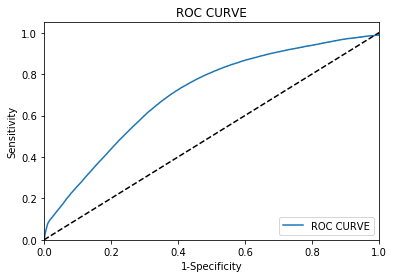

In [74]:
import matplotlib.pylab as plt

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [76]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
mod_fit = rf.fit(Train_DF, y_train)
pred = mod_fit.predict(Test_DF)
metrics.accuracy_score(y_test, pred)
print(metrics.accuracy_score(y_test, pred))

0.941926


In [77]:
cf = confusion_matrix(y_test, pred, labels=None, sample_weight=None)
numDelinqProper = cf[1][1]
numnondelinqimproper = cf[0][1]
numRecordsInDataset = y_test.count()
numPredictedDelinq = cf[1][0] + cf[1][1]
numActualDelinq = y_test[y_test == 1].count()

record = str(numActualDelinq) + "," + str(numPredictedDelinq) + "," + str(numRecordsInDataset) + "," + str(numDelinqProper) + "," + str(numnondelinqimproper)

print(record)

print (metrics.confusion_matrix(y_test,pred))

22618,22618,500000,1731,8150
[[469232   8150]
 [ 20887   1731]]


In [78]:
preds = rf.predict_proba(Test_DF)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

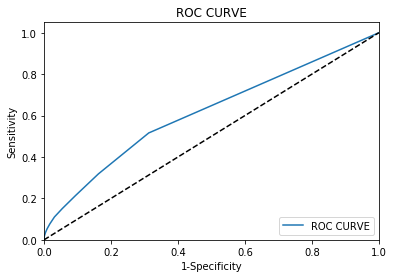

In [79]:
plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [80]:
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier()
mod_fit = nn.fit(Train_DF, y_train)
pred = mod_fit.predict(Test_DF)
metrics.accuracy_score(y_test, pred)
print(metrics.accuracy_score(y_test, pred))

0.954764


In [81]:
cf = confusion_matrix(y_test, pred, labels=None, sample_weight=None)
numDelinqProper = cf[1][1]
numnondelinqimproper = cf[0][1]
numRecordsInDataset = y_test.count()
numPredictedDelinq = cf[1][0] + cf[1][1]
numActualDelinq = y_test[y_test == 1].count()

record = str(numActualDelinq) + "," + str(numPredictedDelinq) + "," + str(numRecordsInDataset) + "," + str(numDelinqProper) + "," + str(numnondelinqimproper)

print(record)

print (metrics.confusion_matrix(y_test,pred))

22618,22618,500000,0,0
[[477382      0]
 [ 22618      0]]


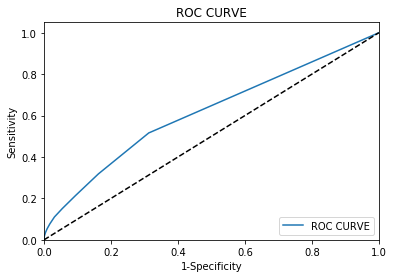

In [82]:
preds = rf.predict_proba(Test_DF)[:,1]
fpr,tpr, _ = roc_curve(y_test,preds)

plt.figure()
plt.plot(fpr,tpr,label= "ROC CURVE")
plt.plot([0,1],[0,1],'k--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [128]:
from tpot import TPOTRegressor
tpot = TPOTRegressor(generations=2, population_size=3,
                     offspring_size=None,
                     mutation_rate=0.9,
                     verbosity=3,cv=2,n_jobs=-1)

In [129]:
tpot.fit(Train_DF,y_train)

28 operators have been imported by TPOT.


_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='epsilon_insensitive' are not supported when dual=False, Parameters: penalty='l2', loss='epsilon_insensitive', dual=False
Generation 1 - Current Pareto front scores:
-1	-0.0433973627841599	ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.3, ExtraTreesRegressor__min_samples_leaf=18, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100)

Skipped pipeline #8 due to time out. Continuing to the next pipeline.
Generation 2 - Current Pareto front scores:
-1	-0.0433973627841599	ExtraTreesRegressor(input_matrix, ExtraTreesRegressor__bootstrap=False, ExtraTreesRegressor__max_features=0.3, ExtraTreesRegressor__min_samples_leaf=18, ExtraTreesRegressor__min_samples_split=5, ExtraTreesRegressor__n_estimators=100)



TPOTRegressor(config_dict=None, crossover_rate=0.1, cv=2,
       disable_update_check=False, early_stop=None, generations=2,
       max_eval_time_mins=5, max_time_mins=None, memory=None,
       mutation_rate=0.9, n_jobs=-1, offspring_size=None,
       periodic_checkpoint_folder=None, population_size=3,
       random_state=None, scoring=None, subsample=1.0, use_dask=False,
       verbosity=3, warm_start=False)

In [131]:
print('The RMSE of TPOT Regressor is {}'.format(tpot.score(Test_DF,y_test)))

The RMSE of TPOT Regressor is -0.040850945121599334


In [86]:
from sklearn.metrics import *
from IPython.core.display import HTML
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [88]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,14 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.0.2
H2O cluster version age:,8 days
H2O cluster name:,H2O_from_python_achar_9ss7cm
H2O cluster total nodes:,1
H2O cluster free memory:,3.511 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


In [112]:
H2o_Train = df.filter(['svcg_cycle','current_upb','loan_age',
           'mths_remng','current_int_rt','non_int_brng_upb','new_delinq'], axis=1)

H2o_Train.columns

Index(['svcg_cycle', 'current_upb', 'loan_age', 'mths_remng', 'current_int_rt',
       'non_int_brng_upb', 'new_delinq'],
      dtype='object')

In [121]:
H2o_Test = test_df.filter(['svcg_cycle','current_upb','loan_age',
           'mths_remng','current_int_rt','non_int_brng_upb','new_delinq'], axis=1)

H2o_Test.columns

Index(['svcg_cycle', 'current_upb', 'loan_age', 'mths_remng', 'current_int_rt',
       'non_int_brng_upb', 'new_delinq'],
      dtype='object')

In [113]:
train = h2o.H2OFrame(H2o_Train)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [114]:
train = train.head(10000)

In [122]:
test = h2o.H2OFrame(H2o_Test)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [123]:
test = test.head(10000)

In [117]:
x = train.columns
y = 'new_delinq'
x.remove(y)

In [118]:
gbm_fit1 = H2OGradientBoostingEstimator(model_id='gbm_fit1', seed=1)

In [119]:
gbm_fit1.train(x=x, y=y, training_frame=train)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [124]:
gbm_perf1 = gbm_fit1.model_performance(test)

In [132]:
print(gbm_perf1)


ModelMetricsRegression: gbm
** Reported on test data. **

MSE: 0.04125400617007638
RMSE: 0.20311082238540706
MAE: 0.06826421343020365
RMSLE: 0.14411790481832826
Mean Residual Deviance: 0.04125400617007638

